# Baseline CNN

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
!python -m pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)


In [4]:
repo_path = 'dataset'
csv_path = os.path.join(repo_path, 'data', 'legend.csv')
images_path = os.path.join(repo_path, 'images')

df = pd.read_csv(csv_path)
df['emotion'] = df['emotion'].str.lower()

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['emotion'], random_state=42
)

train_df, val_df = train_test_split(
    train_df, test_size=0.15, stratify=train_df['emotion'], random_state=42
)

print(len(train_df), len(val_df), len(test_df))

9309 1643 2738


In [5]:
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['emotion'])
val_df['label'] = le.transform(val_df['emotion'])
test_df['label'] = le.transform(test_df['emotion'])

num_classes = len(le.classes_)
print("Classes:", le.classes_)

Classes: ['anger' 'contempt' 'disgust' 'fear' 'happiness' 'neutral' 'sadness'
 'surprise']


In [6]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weights = torch.tensor(class_weights, dtype=torch.float32)
print("Class Weights:", class_weights)

Class Weights: tensor([  6.7653, 193.9375,   8.2527,  83.1161,   0.3004,   0.2492,   6.3586,
          4.6545])


In [7]:
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [8]:
class EmotionDataset(Dataset):
    def __init__(self, df, images_path, transform=None):
        self.df = df.reset_index(drop=True)
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'image']
        label = self.df.loc[idx, 'label']

        img_path = os.path.join(self.images_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(img)

        return img, label

In [9]:
train_dataset = EmotionDataset(train_df, images_path, train_transform)
val_dataset   = EmotionDataset(val_df, images_path, val_test_transform)
test_dataset  = EmotionDataset(test_df, images_path, val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [22]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=15):
    model.to(device)

    train_accs, val_accs = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        
        model.train()
        correct, total, running_loss = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = correct / total
        train_loss = running_loss / len(train_loader)

        
        model.eval()
        correct, total, running_loss = 0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                running_loss += loss.item()

                preds = outputs.argmax(1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = correct / total
        val_loss = running_loss / len(val_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}, "
              f"Train Loss={train_loss:.3f}, Val Loss={val_loss:.3f}")

    return {
        "train_accs": train_accs,
        "val_accs": val_accs,
        "train_losses": train_losses,
        "val_losses": val_losses
    }


def evaluate_on_test(model, test_loader, device, label_encoder):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


def plot_learning_curves(history, title_prefix="Model"):
    train_accs = history["train_accs"]
    val_accs = history["val_accs"]
    train_losses = history["train_losses"]
    val_losses = history["val_losses"]

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(train_accs, label='Train')
    plt.plot(val_accs, label='Val')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

In [10]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BaselineCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_accs, val_accs = [], []
train_losses, val_losses = [], []

epochs = 15

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / len(train_loader)

    model.eval()
    correct, total, running_loss = 0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = running_loss / len(val_loader)

    train_accs.append(train_acc)
    val_accs.append(val_acc)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Acc={train_acc:.3f}, Val Acc={val_acc:.3f}")


Epoch 1: Train Acc=0.326, Val Acc=0.502
Epoch 2: Train Acc=0.354, Val Acc=0.396
Epoch 3: Train Acc=0.438, Val Acc=0.456
Epoch 4: Train Acc=0.438, Val Acc=0.460
Epoch 5: Train Acc=0.425, Val Acc=0.435
Epoch 6: Train Acc=0.399, Val Acc=0.492
Epoch 7: Train Acc=0.378, Val Acc=0.497
Epoch 8: Train Acc=0.396, Val Acc=0.533
Epoch 9: Train Acc=0.388, Val Acc=0.551
Epoch 10: Train Acc=0.439, Val Acc=0.456
Epoch 11: Train Acc=0.435, Val Acc=0.515
Epoch 12: Train Acc=0.444, Val Acc=0.520
Epoch 13: Train Acc=0.468, Val Acc=0.546
Epoch 14: Train Acc=0.488, Val Acc=0.481
Epoch 15: Train Acc=0.469, Val Acc=0.598


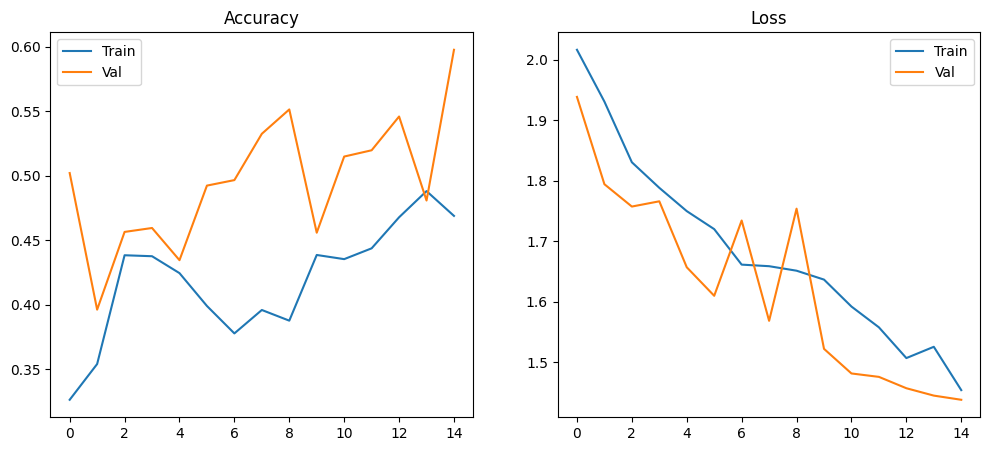

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Val')
plt.title("Loss")
plt.legend()

In [14]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

       anger       0.10      0.46      0.17        50
    contempt       0.00      0.00      0.00         2
     disgust       0.17      0.83      0.28        42
        fear       0.00      0.00      0.00         4
   happiness       0.72      0.72      0.72      1139
     neutral       0.80      0.48      0.60      1374
     sadness       0.05      0.06      0.05        53
    surprise       0.15      0.59      0.24        74

    accuracy                           0.58      2738
   macro avg       0.25      0.39      0.26      2738
weighted avg       0.71      0.58      0.62      2738



c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

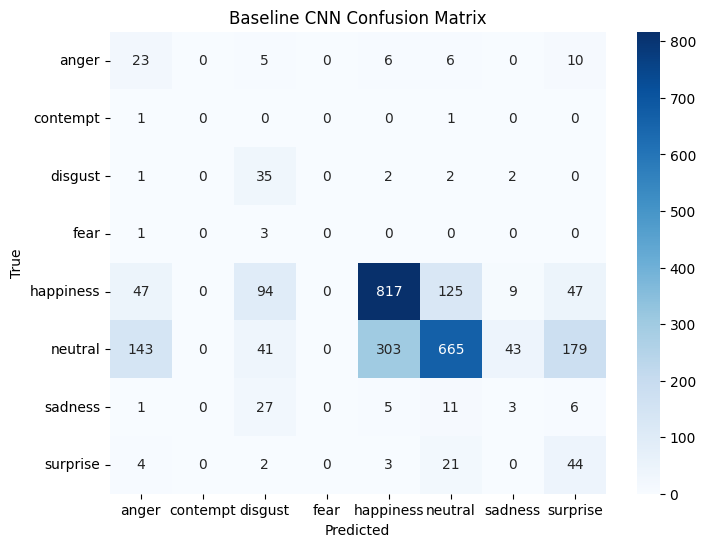

In [ ]:
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels=le.cx`lasses_, yticklabels=le.classes_,
            annot=True, fmt="d", cmap="Blues")
plt.title("Baseline CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# CNN with CBAM Attention

In [23]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super().__init__()
        hidden = max(in_channels // reduction_ratio, 4)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Conv2d(in_channels, hidden, kernel_size=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(hidden, in_channels, kernel_size=1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.mlp(self.avg_pool(x))
        max_out = self.mlp(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_map = torch.mean(x, dim=1, keepdim=True)
        max_map, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_map, max_map], dim=1)
        out = self.conv(x_cat)
        return self.sigmoid(out)


class CBAMBlock(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16, spatial_kernel=7):
        super().__init__()
        self.channel_att = ChannelAttention(in_channels, reduction_ratio)
        self.spatial_att = SpatialAttention(spatial_kernel)

    def forward(self, x):
        # Channel attention
        ca = self.channel_att(x)
        x = x * ca
        # Spatial attention
        sa = self.spatial_att(x)
        x = x * sa
        return x

In [24]:
class AttentionCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            CBAMBlock(32),
            nn.MaxPool2d(2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            CBAMBlock(64),
            nn.MaxPool2d(2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            CBAMBlock(128),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

Epoch 1/15 | Train Acc=0.361, Val Acc=0.416, Train Loss=1.973, Val Loss=1.950
Epoch 2/15 | Train Acc=0.415, Val Acc=0.502, Train Loss=1.968, Val Loss=1.950
Epoch 3/15 | Train Acc=0.455, Val Acc=0.487, Train Loss=1.948, Val Loss=1.951
Epoch 4/15 | Train Acc=0.423, Val Acc=0.502, Train Loss=1.953, Val Loss=1.951
Epoch 5/15 | Train Acc=0.456, Val Acc=0.502, Train Loss=1.948, Val Loss=1.951
Epoch 6/15 | Train Acc=0.452, Val Acc=0.502, Train Loss=1.947, Val Loss=1.945
Epoch 7/15 | Train Acc=0.457, Val Acc=0.502, Train Loss=1.951, Val Loss=1.951
Epoch 8/15 | Train Acc=0.462, Val Acc=0.502, Train Loss=1.954, Val Loss=1.947
Epoch 9/15 | Train Acc=0.460, Val Acc=0.416, Train Loss=1.939, Val Loss=1.947
Epoch 10/15 | Train Acc=0.466, Val Acc=0.416, Train Loss=1.933, Val Loss=1.945
Epoch 11/15 | Train Acc=0.417, Val Acc=0.416, Train Loss=1.937, Val Loss=1.966
Epoch 12/15 | Train Acc=0.438, Val Acc=0.502, Train Loss=1.943, Val Loss=1.947
Epoch 13/15 | Train Acc=0.445, Val Acc=0.502, Train Loss=1.93

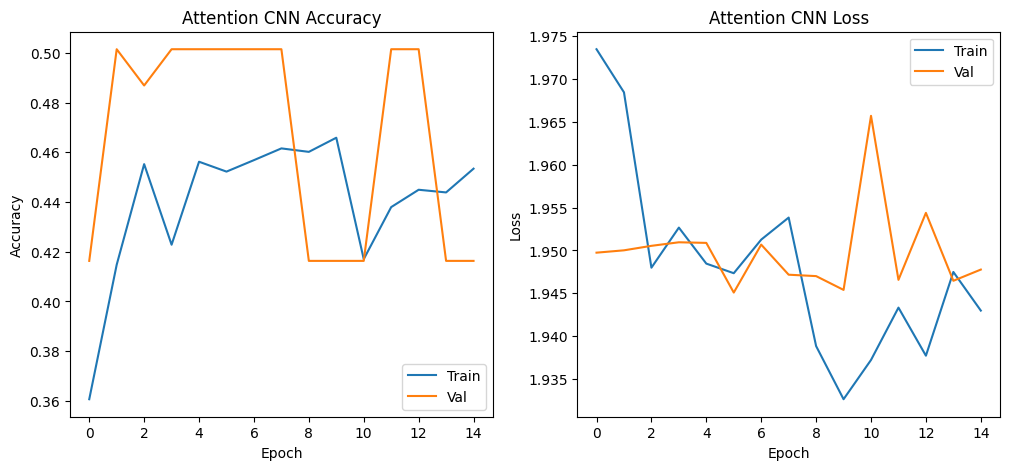

In [28]:
attention_model = AttentionCNN(num_classes).to(device)

criterion_attn = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_attn = optim.Adam(attention_model.parameters(), lr=1e-3)

history_attn = train_model(
    attention_model,
    train_loader,
    val_loader,
    criterion_attn,
    optimizer_attn,
    device,
    epochs=15
)

plot_learning_curves(history_attn, title_prefix="Attention CNN")

=== Attention CNN Test Performance ===


c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\uvvss\miniconda3\envs\cs178\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.sh

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        50
    contempt       0.00      0.00      0.00         2
     disgust       0.00      0.00      0.00        42
        fear       0.00      0.00      0.00         4
   happiness       0.42      1.00      0.59      1139
     neutral       0.00      0.00      0.00      1374
     sadness       0.00      0.00      0.00        53
    surprise       0.00      0.00      0.00        74

    accuracy                           0.42      2738
   macro avg       0.05      0.12      0.07      2738
weighted avg       0.17      0.42      0.24      2738



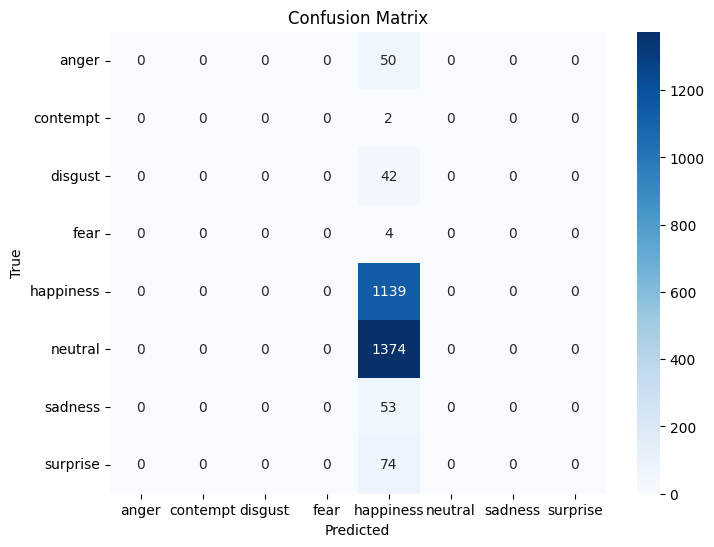

In [29]:
print("=== Attention CNN Test Performance ===")
evaluate_on_test(attention_model, test_loader, device, le)

# Transfer Learning: ResNet18

In [30]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transfer_train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

transfer_val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [31]:
transfer_train_dataset = EmotionDataset(train_df, images_path, transfer_train_transform)
transfer_val_dataset   = EmotionDataset(val_df, images_path, transfer_val_test_transform)
transfer_test_dataset  = EmotionDataset(test_df, images_path, transfer_val_test_transform)

transfer_train_loader = DataLoader(transfer_train_dataset, batch_size=32, shuffle=True)
transfer_val_loader   = DataLoader(transfer_val_dataset, batch_size=32, shuffle=False)
transfer_test_loader  = DataLoader(transfer_test_dataset, batch_size=32, shuffle=False)

# Transfer Learning: EfficientNet-B0

In [33]:
try:
    from torchvision import transforms, models
    from torchvision.models import ResNet18_Weights
    resnet_weights = ResNet18_Weights.IMAGENET1K_V1
    resnet18 = models.resnet18(weights=resnet_weights)
except Exception:
    resnet18 = models.resnet18(pretrained=True)

# Option: fine-tune everything
for param in resnet18.parameters():
    param.requires_grad = True

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, num_classes)
resnet18 = resnet18.to(device)

criterion_resnet = nn.CrossEntropyLoss(weight=class_weights.to(device))
params_to_update = [p for p in resnet18.parameters() if p.requires_grad]
optimizer_resnet = optim.Adam(params_to_update, lr=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\uvvss/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


Epoch 1/10 | Train Acc=0.581, Val Acc=0.618, Train Loss=1.407, Val Loss=1.130
Epoch 2/10 | Train Acc=0.706, Val Acc=0.744, Train Loss=1.021, Val Loss=1.075
Epoch 3/10 | Train Acc=0.757, Val Acc=0.693, Train Loss=0.815, Val Loss=1.105
Epoch 4/10 | Train Acc=0.775, Val Acc=0.712, Train Loss=0.644, Val Loss=1.236
Epoch 5/10 | Train Acc=0.807, Val Acc=0.715, Train Loss=0.550, Val Loss=1.156
Epoch 6/10 | Train Acc=0.822, Val Acc=0.802, Train Loss=0.447, Val Loss=1.241
Epoch 7/10 | Train Acc=0.849, Val Acc=0.737, Train Loss=0.373, Val Loss=1.164
Epoch 8/10 | Train Acc=0.844, Val Acc=0.800, Train Loss=0.366, Val Loss=1.437
Epoch 9/10 | Train Acc=0.838, Val Acc=0.806, Train Loss=0.370, Val Loss=1.053
Epoch 10/10 | Train Acc=0.873, Val Acc=0.834, Train Loss=0.254, Val Loss=1.373


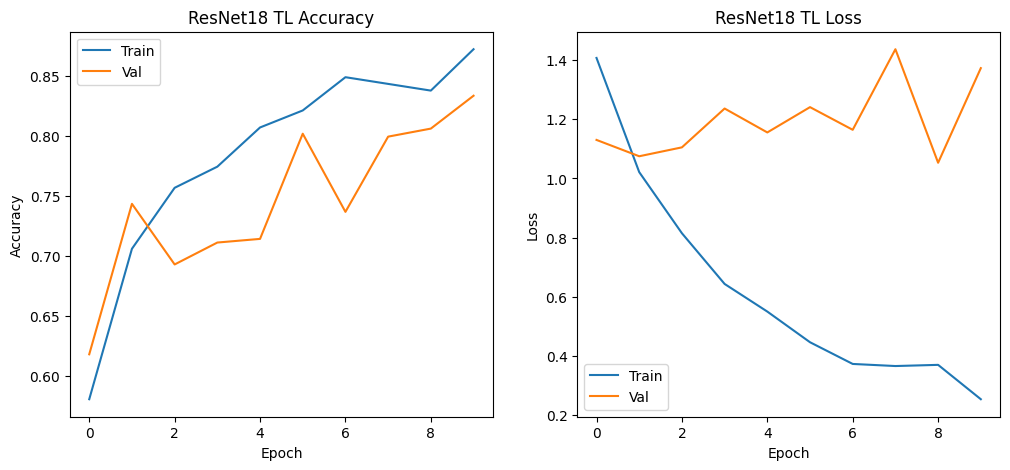

=== ResNet18 Transfer Learning Test Performance ===
              precision    recall  f1-score   support

       anger       0.42      0.48      0.45        50
    contempt       0.00      0.00      0.00         2
     disgust       0.33      0.67      0.44        42
        fear       0.00      0.00      0.00         4
   happiness       0.92      0.89      0.90      1139
     neutral       0.92      0.85      0.88      1374
     sadness       0.28      0.47      0.35        53
    surprise       0.36      0.64      0.46        74

    accuracy                           0.84      2738
   macro avg       0.40      0.50      0.44      2738
weighted avg       0.87      0.84      0.85      2738



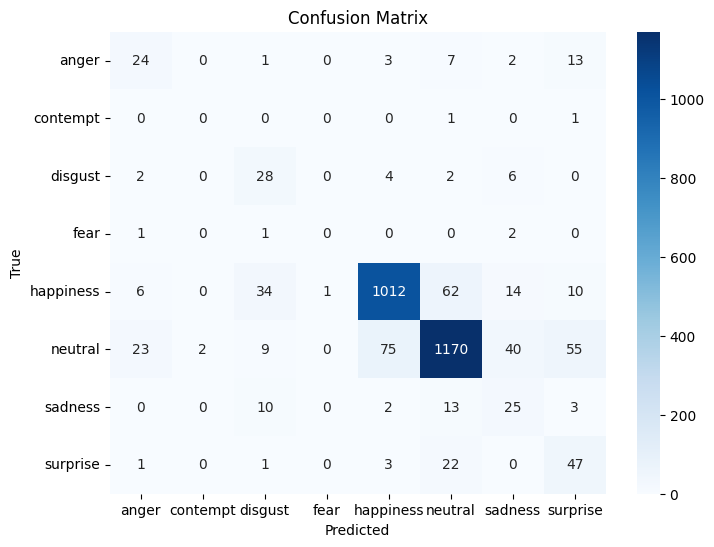

In [34]:
history_resnet = train_model(
    resnet18,
    transfer_train_loader,
    transfer_val_loader,
    criterion_resnet,
    optimizer_resnet,
    device,
    epochs=10
)

plot_learning_curves(history_resnet, title_prefix="ResNet18 TL")

print("=== ResNet18 Transfer Learning Test Performance ===")
evaluate_on_test(resnet18, transfer_test_loader, device, le)

 # Vision Transformer (ViT)